In [48]:
!pip install statsmodels

In [49]:
!pip install pmdarima

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA


### Box Jenkins Method (details):

1. Apply transformations to make time series stationary (detrending, transformations, differencing).
2. If differencing, keep track of order d of differencing. Don't overdifference!
3. Confirm stationarity (visually, ACF, ADF test)
4. Plot ACF/PACF, identify likely AR and MA orders p, q.
5. Fit original (non-differenced) data with ARIMA model of order p, d, q
6. Try a few other values around these orders
7. Of all models with similarly low AIC, pick the least complex one
8. Inspect residuals: If ACF and PACF show white noise (no signal left)➔ You are done.
9. Otherwise ➔ Iterate (Try other transformations, change order of differencing, Add/Remove MA/AR terms)
10. Compare with Auto-ARIMA output trace


In [51]:
# Reading Data
data = pd.read_excel('../raw_data/weekly_data_clean.xlsx', engine='openpyxl')

In [52]:
data

,Unnamed: 0,date_issue,total_amount_claims
0,0,2018-09-03,16683
1,1,2018-09-10,201774
2,2,2018-09-17,263661
3,3,2018-09-24,799703
4,4,2018-10-01,900305
...,...,...,...
127,127,2021-02-08,1949930
128,128,2021-02-15,1725225
129,129,2021-02-22,2232202
130,130,2021-03-01,2666662


In [53]:
# Dropping extra index column
data = data.drop(columns= 'Unnamed: 0')

In [54]:
data.isnull().sum()

date_issue             0
total_amount_claims    0
dtype: int64

In [55]:
# Check types and lenght
data.dtypes, len(data)

(date_issue             datetime64[ns]
 total_amount_claims             int64
 dtype: object,
 132)

<AxesSubplot:xlabel='date_issue'>

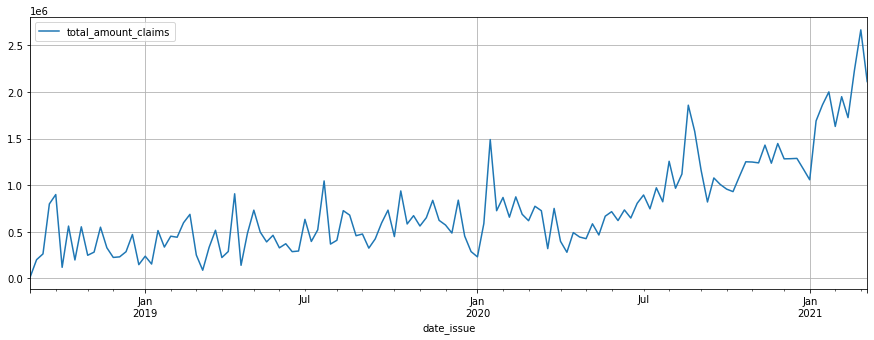

In [56]:
# Setting index as date, to plot time series
data_di = data.set_index('date_issue')

#Plotting
data_di.plot(grid=True, figsize=(15,5))

In [57]:
data_di.head()

,total_amount_claims
date_issue,
2018-09-03,16683
2018-09-10,201774
2018-09-17,263661
2018-09-24,799703
2018-10-01,900305


#### 1. Apply transformations to make time series stationary (detrending, transformations, differencing).

<AxesSubplot:xlabel='date_issue'>

<Figure size 1440x720 with 0 Axes>

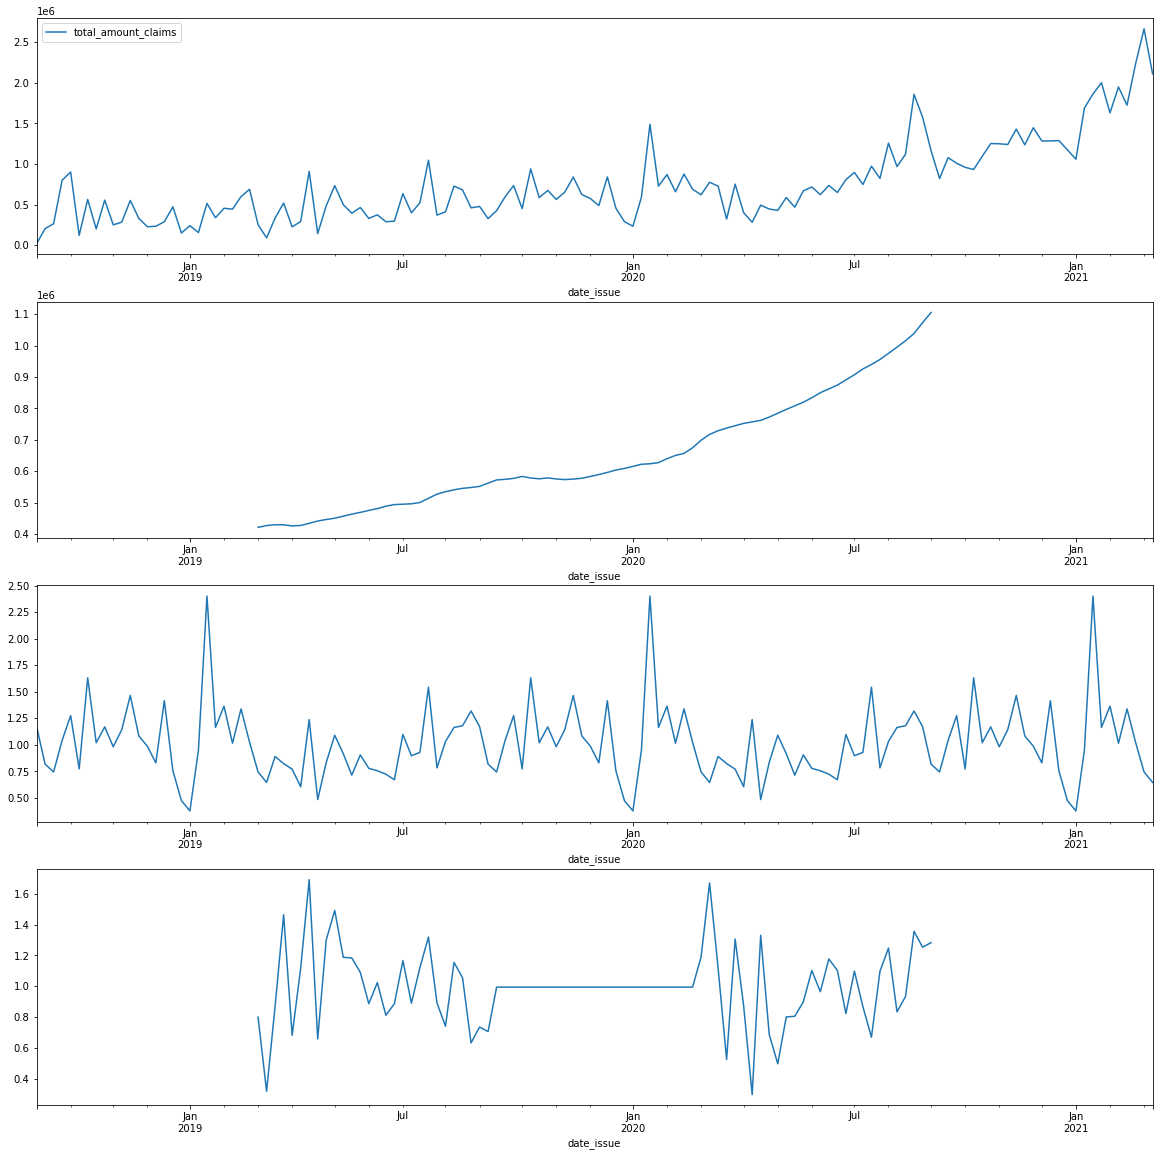

In [58]:
# Applying seasonal decompose

#First we try multiplicative
res_mul = seasonal_decompose(data_di, model='multiplicative')
plt.figure(figsize=(20,10))

fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(20,20))
data_di.plot(ax=ax1)
res_mul.trend.plot(ax=ax2)
res_mul.seasonal.plot(ax=ax3)
res_mul.resid.plot(ax=ax4)



<AxesSubplot:xlabel='date_issue'>

<Figure size 1440x720 with 0 Axes>

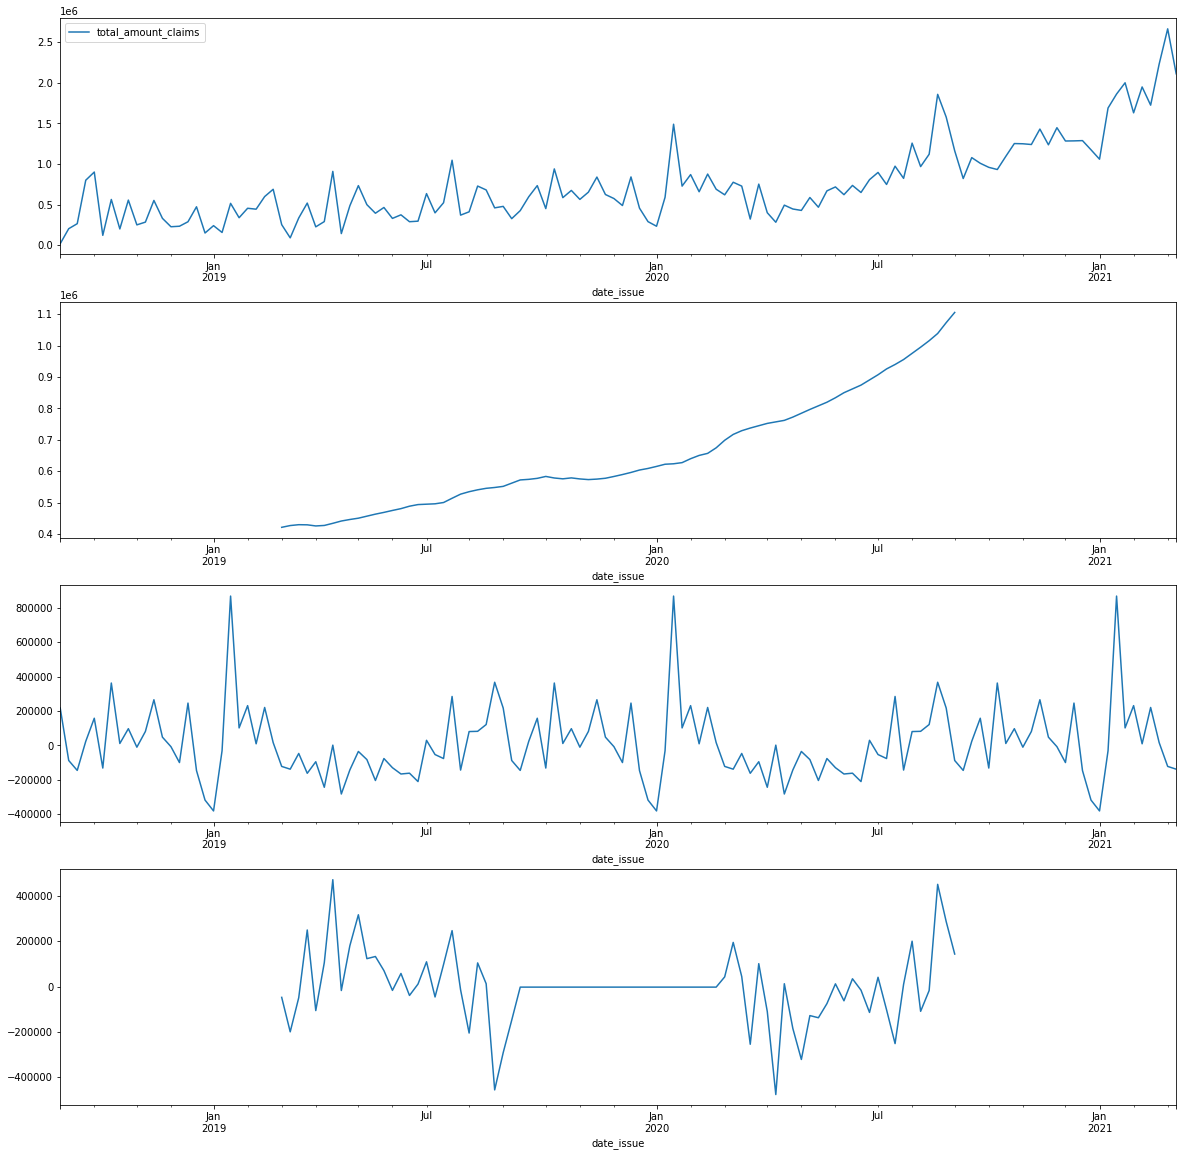

In [59]:
# Now we try additive
res_add = seasonal_decompose(data_di, model='additive')
plt.figure(figsize=(20,10))

fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(20,20))
data_di.plot(ax=ax1)
res_add.trend.plot(ax=ax2)
res_add.seasonal.plot(ax=ax3)
res_add.resid.plot(ax=ax4)


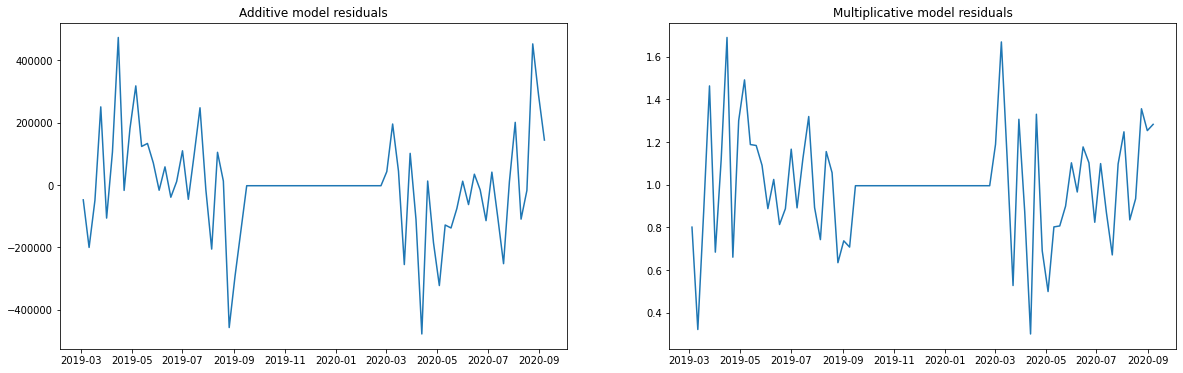

In [60]:
# Plot the residuals with "result_add.resid" to decide
f, (ax1, ax2) = plt.subplots(1,2, figsize=(20,6))
ax1.plot(res_add.resid); ax1.set_title("Additive model residuals")
ax2.plot(res_mul.resid); ax2.set_title("Multiplicative model residuals");

# Multiplicative seems better (residuals less dependent from time)

In [61]:
res_add.resid.isnull().sum()

52

In [62]:
# Checking stationarity in original data

pvalue_y = adfuller(data_di)[1]
pvalue_y
def stationary(pvalue):
    if pvalue < 0.05:
        print('TS is stationary')
    else:
        print('TS is not stationary')
stationary(pvalue_y), pvalue_y


TS is not stationary


(None, 0.9820064277979804)

In [63]:
# Checking stationarity in multiplicative decomposed serie
mul_resid_ts = res_mul.resid.dropna()
pvalue_y_mul = adfuller(mul_resid_ts)[1]
stationary(pvalue_y_mul), pvalue_y_mul

TS is stationary


(None, 0.013005491972087026)

In [64]:
# Checking stationarity in additive decomposed serie
add_resid_ts = res_add.resid.dropna()
pvalue_y_add = adfuller(add_resid_ts)[1]
stationary(pvalue_y_add), pvalue_y_add

TS is stationary


(None, 0.013592386018843048)

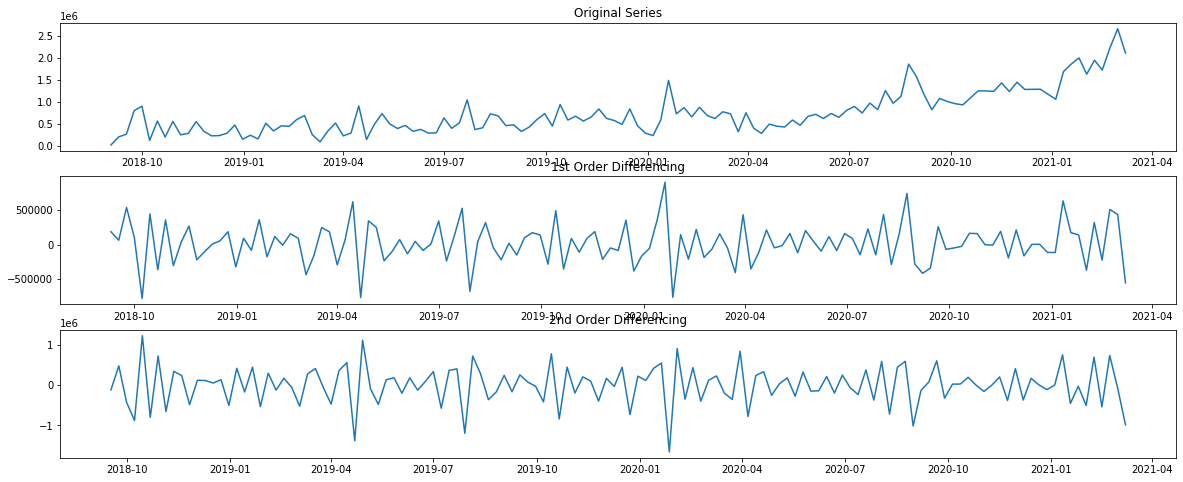

In [65]:
# Differencing original series (exploring)

data_di_diff_1 = data_di.diff(1).dropna()
data_di_diff_2 = data_di.diff(1).diff(1).dropna()
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20,8))
ax1.plot(data_di); ax1.set_title('Original Series')
ax2.plot(data_di_diff_1); ax2.set_title('1st Order Differencing')
ax3.plot(data_di_diff_2); ax3.set_title('2nd Order Differencing');

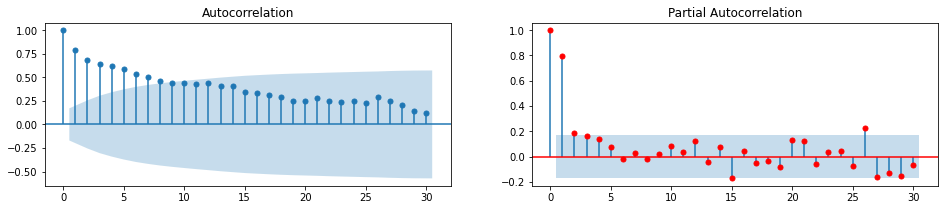

In [66]:
## ACF y PACF of original serie
fig, axes = plt.subplots(1,2, figsize=(16,3))
plot_acf(data_di, lags=30, ax=axes[0]);
plot_pacf(data_di, lags=30, ax=axes[1], color='r');

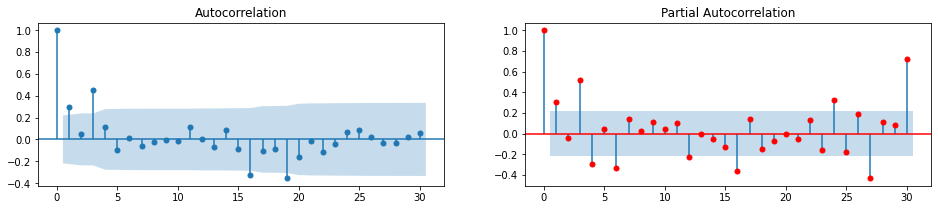

In [67]:
# Checking additive residuals ACF and PACF
fig, axes = plt.subplots(1,2, figsize=(16,3))
plot_acf(add_resid_ts, lags=30, ax=axes[0]);
plot_pacf(add_resid_ts, lags=30, ax=axes[1], color='r');

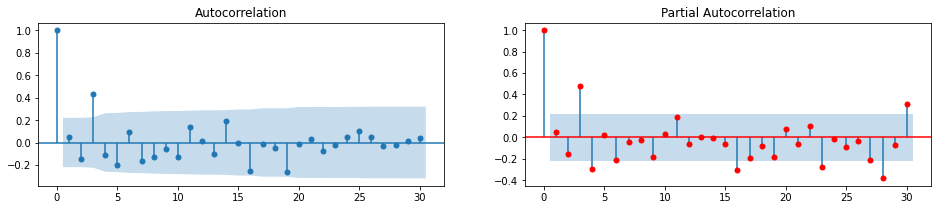

In [68]:
# Checking multiplicative residuals ACF and PACF
fig, axes = plt.subplots(1,2, figsize=(16,3))
plot_acf(mul_resid_ts, lags=30, ax=axes[0]);
plot_pacf(mul_resid_ts, lags=30, ax=axes[1], color='r');

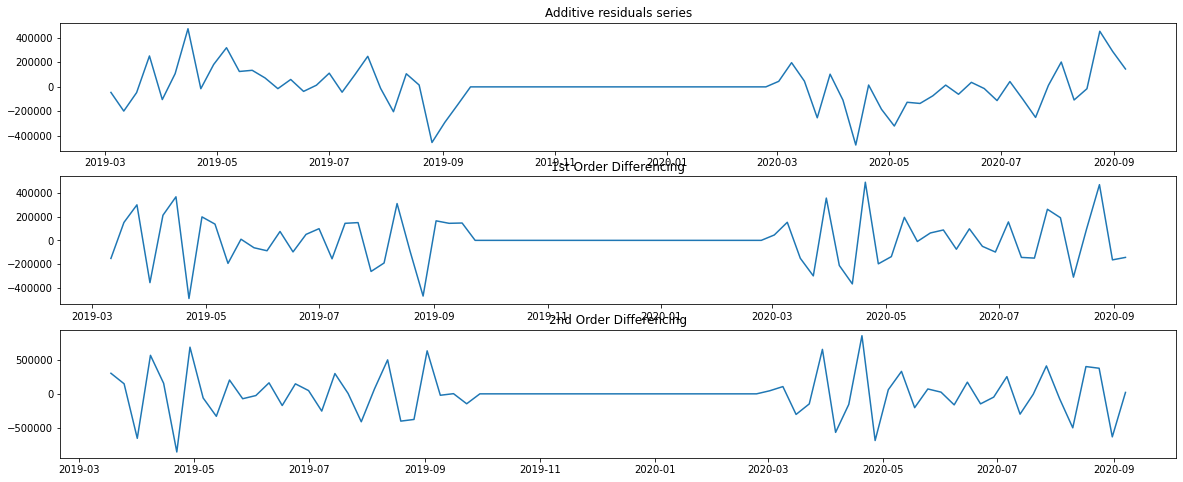

In [69]:
# Differencing additive residuals series
add_resid_ts_diff_1 = add_resid_ts.diff(1).dropna()
add_resid_ts_diff_2 = add_resid_ts.diff(1).diff(1).dropna()
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20,8))
ax1.plot(add_resid_ts); ax1.set_title('Additive residuals series')
ax2.plot(add_resid_ts_diff_1); ax2.set_title('1st Order Differencing')
ax3.plot(add_resid_ts_diff_2); ax3.set_title('2nd Order Differencing');

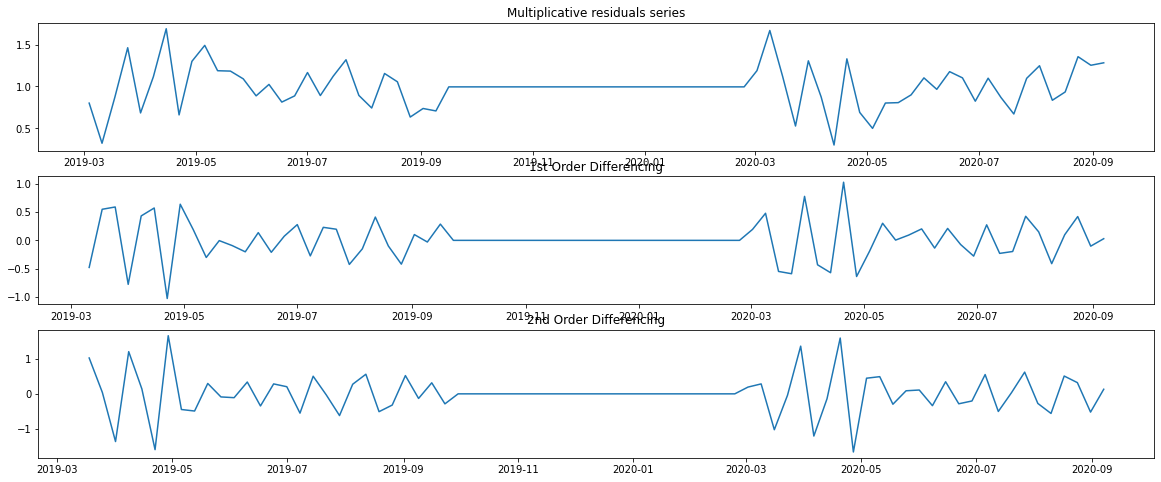

In [70]:
# Differencing multiplicative residuals series
mul_resid_ts_diff_1 = mul_resid_ts.diff(1).dropna()
mul_resid_ts_diff_2 = mul_resid_ts.diff(1).diff(1).dropna()
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20,8))
ax1.plot(mul_resid_ts); ax1.set_title('Multiplicative residuals series')
ax2.plot(mul_resid_ts_diff_1); ax2.set_title('1st Order Differencing')
ax3.plot(mul_resid_ts_diff_2); ax3.set_title('2nd Order Differencing');

ValueError: Can only compute partial correlations for lags up to 50% of the sample size. The requested nlags 60 must be < 39.

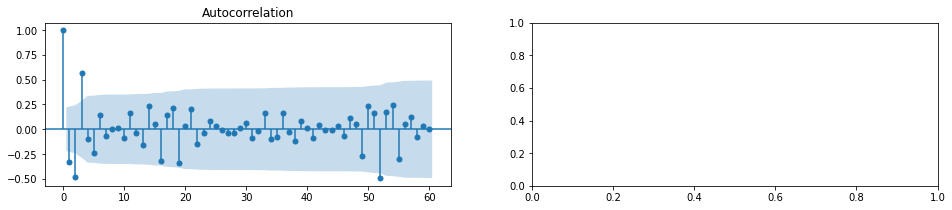

In [71]:
# Checking additive residuals diff 1 ACF and PACF
fig, axes = plt.subplots(1,2, figsize=(16,3))
plot_acf(add_resid_ts_diff_1, lags=60, ax=axes[0]);
plot_pacf(add_resid_ts_diff_1, lags=60, ax=axes[1], color='r');

In [ ]:
# Checking multiplicative residuals diff 1 ACF and PACF
fig, axes = plt.subplots(1,2, figsize=(16,3))
plot_acf(mul_resid_ts_diff_1, lags=60, ax=axes[0]);
plot_pacf(mul_resid_ts_diff_1, lags=60, ax=axes[1], color='r');

In [73]:
# Splitting data
# Additive serie
split_1 = 0.7
split_index_1 = round(len(add_resid_ts)*split_1)

add_resid_ts_train = add_resid_ts.iloc[:split_index_1]
add_resid_ts_test = add_resid_ts.iloc[split_index_1:]

add_resid_ts_train.head(), add_resid_ts_train.tail(), add_resid_ts_test.head(), add_resid_ts_test.tail()


(date_issue
 2019-03-04    -47656.737888
 2019-03-11   -200151.444619
 2019-03-18    -49148.175388
 2019-03-25    250386.637112
 2019-04-01   -106113.439811
 Name: resid, dtype: float64,
 date_issue
 2020-02-24     -2356.435004
 2020-03-02     42943.867881
 2020-03-09    195438.574612
 2020-03-16     44435.305381
 2020-03-23   -255099.507119
 Name: resid, dtype: float64,
 date_issue
 2020-03-30    101400.569804
 2020-04-06   -110364.853273
 2020-04-13   -477604.891734
 2020-04-20     12666.108266
 2020-04-27   -185305.324427
 Name: resid, dtype: float64,
 date_issue
 2020-08-10   -109460.348465
 2020-08-17    -17426.435004
 2020-08-24    452286.834227
 2020-08-31    287672.858266
 2020-09-07    143950.093842
 Name: resid, dtype: float64)

In [74]:
# Splitting data
# Multiplicative serie

split_2 = 0.7
split_index_2 = round(len(mul_resid_ts)*split_2)
mul_resid_ts_train = mul_resid_ts.iloc[:split_index_2]
mul_resid_ts_test = mul_resid_ts.iloc[split_index_2:]

mul_resid_ts_train.head(), mul_resid_ts_train.tail(), mul_resid_ts_test.head(), mul_resid_ts_test.tail()

(date_issue
 2019-03-04    0.800775
 2019-03-11    0.320856
 2019-03-18    0.871554
 2019-03-25    1.462945
 2019-04-01    0.683568
 Name: resid, dtype: float64,
 date_issue
 2020-02-24    0.995006
 2020-03-02    1.189237
 2020-03-09    1.669156
 2020-03-16    1.118458
 2020-03-23    0.527067
 Name: resid, dtype: float64,
 date_issue
 2020-03-30    1.306444
 2020-04-06    0.873309
 2020-04-13    0.299910
 2020-04-20    1.330104
 2020-04-27    0.689684
 Name: resid, dtype: float64,
 date_issue
 2020-08-10    0.834918
 2020-08-17    0.934185
 2020-08-24    1.355892
 2020-08-31    1.253354
 2020-09-07    1.282747
 Name: resid, dtype: float64)

In [75]:
# Trying Auto ARIMA with additive residuals serie
stepwise_fit_add = pm.auto_arima(add_resid_ts_train, start_p=0, start_q=0,
                             max_p=2, max_q=3, m=7,
                             start_P=0, seasonal=True,
                             d=1, D=1, trace=True,
                             error_action='ignore', # don’t want to know if an order does not work
                             suppress_warnings=True) # don’t want convergence warnings)
stepwise_fit_add.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=inf, Time=0.04 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=1322.685, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=1297.439, Time=0.03 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=1293.566, Time=0.03 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=1312.569, Time=0.02 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=1292.413, Time=0.07 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=1292.998, Time=0.04 sec
 ARIMA(0,1,1)(2,1,1)[7]             : AIC=1293.793, Time=0.09 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=1294.262, Time=0.07 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=1292.879, Time=0.05 sec
 ARIMA(0,1,1)(2,1,0)[7]             : AIC=1291.844, Time=0.05 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=1282.525, Time=0.03 sec
 ARIMA(0,1,0)(1,1,0)[7]             : AIC=1291.335, Time=0.02 sec
 ARIMA(0,1,0)(2,1,1)[7]             : AIC=1289.259, Time=0.06 sec
 ARIMA(0,1,0)(1,1,1)[7]             : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                   56
Model:             SARIMAX(0, 1, 0)x(2, 1, 0, 7)   Log Likelihood                -638.263
Date:                           Fri, 12 Mar 2021   AIC                           1282.525
Time:                                   11:35:12   BIC                           1288.139
Sample:                                        0   HQIC                          1284.647
                                            - 56                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7       -0.9002      0.123     -7.302      0.000      -1.142      -0.659
ar.S.L14      -0.3858      0.107     -3.601      0.000      -0.596      -0.176
sigma2       2.01e+10   1.45e-13   1.39e+23      0.000    2.01e+10    2.01e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.97   Jarque-Bera (JB):                 0.01
Prob(Q):                              0.32   Prob(JB):                         0.99
Heteroskedasticity (H):               0.75   Skew:                             0.00
Prob(H) (two-sided):                  0.58   Kurtosis:                         2.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.09e+40. Standard errors may be unstable.
"""

In [76]:

# Trying Auto ARIMA with multiplicative residuals serie
stepwise_fit_mul = pm.auto_arima(mul_resid_ts_train, start_p=0, start_q=0,
                             max_p=2, max_q=3, m=7,
                             start_P=0, seasonal=True,
                             d=1, D=1, trace=True,
                             error_action='ignore', # don’t want to know if an order does not work
                             suppress_warnings=True) # don’t want convergence warnings)
stepwise_fit_mul.summary()


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=43.647, Time=0.12 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=57.959, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=30.663, Time=0.04 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=24.751, Time=0.14 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=19.406, Time=0.09 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=19.487, Time=0.08 sec
 ARIMA(0,1,1)(2,1,1)[7]             : AIC=20.322, Time=0.14 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=19.320, Time=0.14 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=18.634, Time=0.13 sec
 ARIMA(0,1,0)(0,1,2)[7]             : AIC=33.258, Time=0.08 sec
 ARIMA(1,1,1)(0,1,2)[7]             : AIC=19.671, Time=0.16 sec
 ARIMA(0,1,2)(0,1,2)[7]             : AIC=18.883, Time=0.19 sec
 ARIMA(1,1,0)(0,1,2)[7]             : AIC=29.126, Time=0.11 sec
 ARIMA(1,1,2)(0,1,2)[7]             : AIC=15.468, Time=0.22 sec


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   56
Model:             SARIMAX(2, 1, 1)x(1, 1, [], 7)   Log Likelihood                  -1.240
Date:                            Fri, 12 Mar 2021   AIC                             12.480
Time:                                    11:35:18   BIC                             21.836
Sample:                                         0   HQIC                            16.015
                                             - 56                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8666      0.160     -5.400      0.000      -1.181      -0.552
ar.L2         -0.7388      0.110     -6.727      0.000      -0.954      -0.524
ma.L1          0.4114      0.275      1.496      0.135      -0.127       0.950
ar.S.L7       -0.6342      0.153     -4.143      0.000      -0.934      -0.334
sigma2         0.0549      0.012      4.702      0.000       0.032       0.078
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):                 1.10
Prob(Q):                              0.73   Prob(JB):                         0.58
Heteroskedasticity (H):               0.79   Skew:                             0.06
Prob(H) (two-sided):                  0.63   Kurtosis:                         3.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [77]:
# with m=12 AIC = 1954.975, Best Model = ARIMA(2,1,0)(2,1,0)[12] 
# with m=7 AIC =  1769.693, Best Model = ARIMA(2,1,0)(2,1,2)[7]
# with m=1 AIC = 1804.360, Best Model = ARIMA(2,1,0)(0,0,0)[0] 



In [78]:
# We are choosing multiplicative decomposed serie with m=7 because it gives the lower AIC
# Let's predict


resid_pred_mul = stepwise_fit_mul.predict(n_periods=len(mul_resid_ts_test))

In [79]:
resid_pred_mul

array([1.19079228, 1.05256155, 0.68196655, 1.17629332, 1.25884561,
       0.82526244, 0.87881842, 1.059245  , 0.86332214, 0.89979952,
       1.16211495, 1.4057003 , 1.0074841 , 0.62421375, 1.05423163,
       0.96476025, 0.72458252, 1.09844431, 1.28440657, 0.85149326,
       0.7230109 , 1.02308169, 0.85797375, 0.77935038])

In [80]:
pa = pd.DataFrame(mul_resid_ts_test)
pa['resid_pred_mul'] = resid_pred_mul
pa['absolute_error'] = abs(pa['resid'] - pa['resid_pred_mul'])
pa

,resid,resid_pred_mul,absolute_error
date_issue,,,
2020-03-30,1.306444,1.190792,0.115652
2020-04-06,0.873309,1.052562,0.179253
2020-04-13,0.299910,0.681967,0.382057
2020-04-20,1.330104,1.176293,0.153811
2020-04-27,0.689684,1.258846,0.569161
2020-05-04,0.498839,0.825262,0.326424
2020-05-11,0.801858,0.878818,0.076960
2020-05-18,0.806434,1.059245,0.252811
2020-05-25,0.899390,0.863322,0.036068


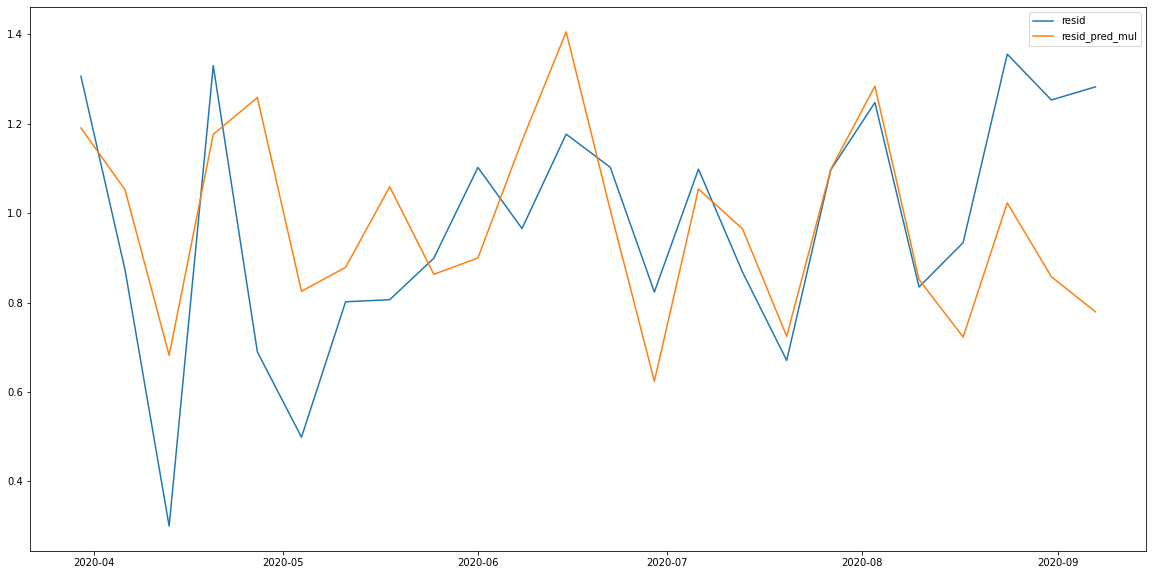

In [81]:
#Plotting residuals

plt.figure(figsize=(20,10))
plt.plot( 'resid', data= pa)
plt.plot( 'resid_pred_mul', data= pa)
plt.legend()

In [82]:
# Plot predict with optimal model
# Build model
best_sarima = SARIMAX(mul_resid_ts_train, order=(2, 1, 0),seasonal_order=(2,1,2,7))
best_sarima = best_sarima.fit()

# Forecast
best_results = best_sarima.get_forecast(len(mul_resid_ts_test), alpha=0.05)
best_forecast = best_results.predicted_mean
best_confidence_int = best_results.conf_int()

/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmode

In [83]:
best_confidence_int

,lower resid,upper resid
2020-03-30,0.859706,1.765874
2020-04-06,0.740948,1.713597
2020-04-13,0.285207,1.260154
2020-04-20,0.571107,1.727438
2020-04-27,0.680132,1.932316
2020-05-04,0.332083,1.597861
2020-05-11,0.333634,1.681214
2020-05-18,0.468340,1.947849
2020-05-25,0.310216,1.825963
2020-06-01,0.229407,1.796760


In [100]:
# re-compose back to initial time series
best_forecast_recons = best_forecast*res_mul.seasonal[split_index_2:]*res_mul.trend[split_index_2:]
train_recons = mul_resid_ts_train*res_mul.seasonal[:split_index_2]*res_mul.trend[:split_index_2]
test_recons = mul_resid_ts_test*res_mul.seasonal[split_index_2:]*res_mul.trend[split_index_2:]
best_upper_recons = best_confidence_int['upper resid']*res_mul.seasonal[split_index_2:]*res_mul.trend[split_index_2:]
best_lower_recons = best_confidence_int['lower resid']*res_mul.seasonal[split_index_2:]*res_mul.trend[split_index_2:]

In [85]:
def plot_forecast(fc, train, test, upper=None, lower=None):
    is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
    # Prepare plot series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(upper, index=test.index) if is_confidence_int else None
    upper_series = pd.Series(lower, index=test.index) if is_confidence_int else None
    # Plot
    plt.figure(figsize=(10,4), dpi=100)
    plt.plot(train, label='training', color='black')
    plt.plot(test, label='actual', color='black', ls='--')
    plt.plot(fc_series, label='forecast', color='orange')
    if is_confidence_int:
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8);

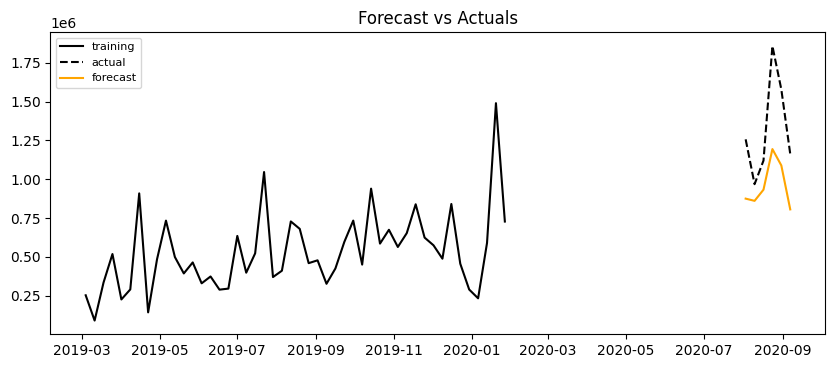

In [101]:
# Plotting 
plot_forecast(best_forecast_recons, train_recons, test_recons, upper = best_upper_recons, lower=best_lower_recons)


In [87]:
test_recons

date_issue
2019-09-30   NaN
2019-10-07   NaN
2019-10-14   NaN
2019-10-21   NaN
2019-10-28   NaN
              ..
2021-02-08   NaN
2021-02-15   NaN
2021-02-22   NaN
2021-03-01   NaN
2021-03-08   NaN
Length: 76, dtype: float64

In [88]:
# computing mae
best_sarima_performance = pd.DataFrame(test_recons)
best_sarima_performance['best_forecast_recons'] = best_forecast_recons
best_sarima_performance.rename(columns={0: 'test_recons'}, inplace=True)

best_sarima_performance.dropna(inplace=True)

best_sarima_performance['absolute_error'] = abs(best_sarima_performance['test_recons'] - best_sarima_performance['best_forecast_recons'])
best_sarima_performance
best_sarima_performance['absolute_error'].mean()



179629.2384460771

### Changing Train/Test split to reduce prediction horizon.

In [89]:
# Splitting data
# Multiplicative serie

split_2 = 0.93
split_index_2 = round(len(mul_resid_ts)*split_2)
mul_resid_ts_train = mul_resid_ts.iloc[:split_index_2]
mul_resid_ts_test = mul_resid_ts.iloc[split_index_2:]

mul_resid_ts_train.head(), mul_resid_ts_train.tail(), mul_resid_ts_test.head(), mul_resid_ts_test.tail()

(date_issue
 2019-03-04    0.800775
 2019-03-11    0.320856
 2019-03-18    0.871554
 2019-03-25    1.462945
 2019-04-01    0.683568
 Name: resid, dtype: float64,
 date_issue
 2020-06-29    0.823665
 2020-07-06    1.098754
 2020-07-13    0.867939
 2020-07-20    0.670561
 2020-07-27    1.097132
 Name: resid, dtype: float64,
 date_issue
 2020-08-03    1.247722
 2020-08-10    0.834918
 2020-08-17    0.934185
 2020-08-24    1.355892
 2020-08-31    1.253354
 Name: resid, dtype: float64,
 date_issue
 2020-08-10    0.834918
 2020-08-17    0.934185
 2020-08-24    1.355892
 2020-08-31    1.253354
 2020-09-07    1.282747
 Name: resid, dtype: float64)

In [90]:
# Trying Auto ARIMA with multiplicative residuals serie
stepwise_fit_mul = pm.auto_arima(mul_resid_ts_train, start_p=0, start_q=0,
                             max_p=2, max_q=3, m=7,
                             start_P=0, seasonal=True,
                             d=1, D=1, trace=True,
                             error_action='ignore', # don’t want to know if an order does not work
                             suppress_warnings=True) # don’t want convergence warnings)
stepwise_fit_mul.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=67.884, Time=0.07 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=102.063, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=49.486, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=0.17 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=87.426, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=43.864, Time=0.10 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=45.688, Time=0.21 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=44.840, Time=0.09 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=55.505, Time=0.07 sec
 ARIMA(2,1,0)(2,1,0)[7]             : AIC=9.037, Time=0.09 sec
 ARIMA(2,1,0)(1,1,0)[7]             : AIC=12.188, Time=0.08 sec
 ARIMA(2,1,0)(2,1,1)[7]             : AIC=8.461, Time=0.36 sec
 ARIMA(2,1,0)(1,1,1)[7]             : AIC=6.821, Time=0.16 sec
 ARIMA(2,1,0)(0,1,1)[7]             : AIC=11.515, Time=0.13 sec
 ARIMA(2,1,0)(1,1,2)[7]             : AIC=8.562, Time=0.25 sec
 AR

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   74
Model:             SARIMAX(2, 1, 0)x(1, 1, [1], 7)   Log Likelihood                   1.589
Date:                             Fri, 12 Mar 2021   AIC                              6.821
Time:                                     11:35:23   BIC                             17.769
Sample:                                          0   HQIC                            11.147
                                              - 74                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6930      0.096     -7.223      0.000      -0.881      -0.505
ar.L2         -0.6853      0.094     -7.270      0.000      -0.870      -0.501
ar.S.L7       -0.4479      0.196     -2.287      0.022      -0.832      -0.064
ma.S.L7       -0.6056      0.215     -2.822      0.005      -1.026      -0.185
sigma2         0.0483      0.008      6.331      0.000       0.033       0.063
===================================================================================
Ljung-Box (L1) (Q):                   0.41   Jarque-Bera (JB):                 4.17
Prob(Q):                              0.52   Prob(JB):                         0.12
Heteroskedasticity (H):               1.04   Skew:                             0.24
Prob(H) (two-sided):                  0.92   Kurtosis:                         4.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [91]:
# Plot predict with optimal model
# Build model
best_sarima = SARIMAX(mul_resid_ts_train, order=(2, 1, 0),seasonal_order=(2,1,2,7))
best_sarima = best_sarima.fit()

# Forecast
best_results = best_sarima.get_forecast(len(mul_resid_ts_test), alpha=0.05)
best_forecast = best_results.predicted_mean
best_confidence_int = best_results.conf_int()

/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


In [92]:
# re-compose back to initial time series
best_forecast_recons = best_forecast*res_mul.seasonal[split_index_2:]*res_mul.trend[split_index_2:]
train_recons = mul_resid_ts_train*res_mul.seasonal[:split_index_2]*res_mul.trend[:split_index_2]
test_recons = mul_resid_ts_test*res_mul.seasonal[split_index_2:]*res_mul.trend[split_index_2:]
best_upper_recons = best_confidence_int['upper resid']*res_mul.seasonal[split_index_2:]*res_mul.trend[split_index_2:]
best_lower_recons = best_confidence_int['lower resid']*res_mul.seasonal[split_index_2:]*res_mul.trend[split_index_2:]

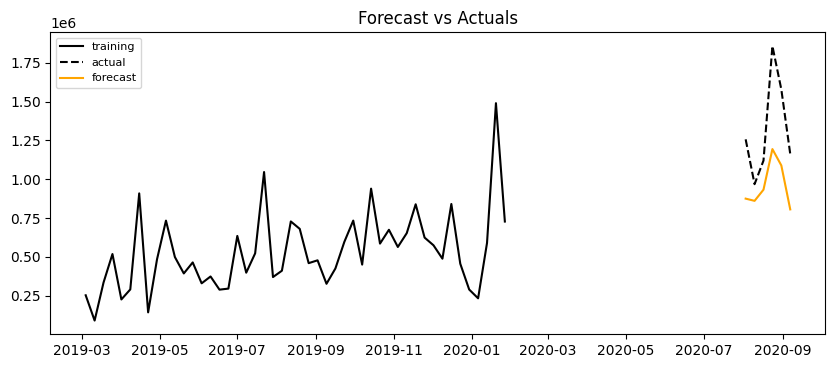

In [93]:
# Plotting 
plot_forecast(best_forecast_recons, train_recons, test_recons, upper = best_upper_recons, lower=best_lower_recons)


In [94]:
# computing mae
best_sarima_performance = pd.DataFrame(test_recons)
best_sarima_performance['best_forecast_recons'] = best_forecast_recons
best_sarima_performance.rename(columns={0: 'test_recons'}, inplace=True)

best_sarima_performance.dropna(inplace=True)

best_sarima_performance['absolute_error'] = abs(best_sarima_performance['test_recons'] - best_sarima_performance['best_forecast_recons'])
best_sarima_performance
best_sarima_performance['absolute_error'].mean()



364842.91896743263

In [95]:
# Reducing test split does not improve performance

### Additional analysis made with Tomi

Text(0.5, 1.0, '7th Order Differencing')

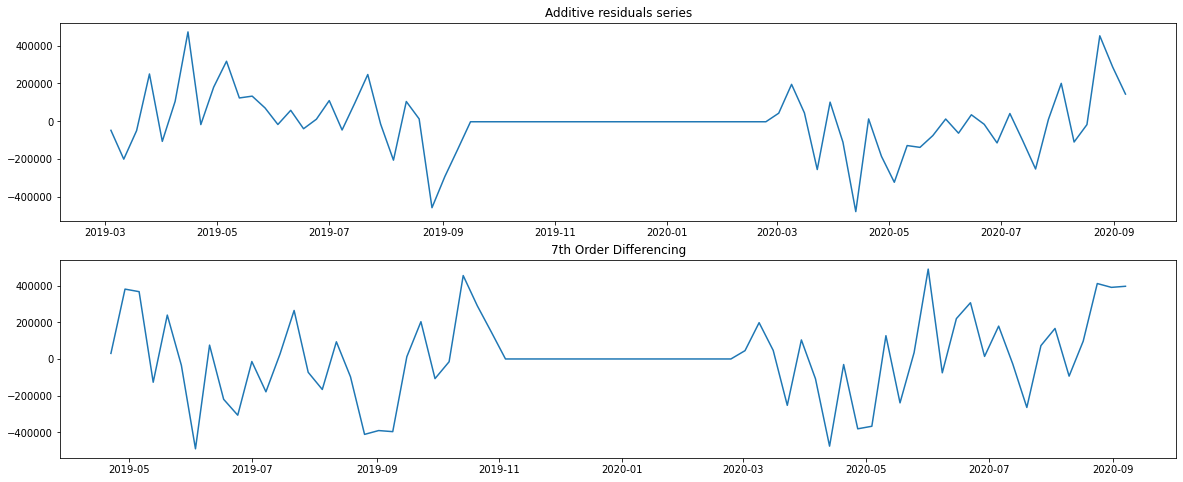

In [96]:


# Differencing additive residuals series by 7 since there seems to be weekly seasonality
add_resid_ts_diff_7 = add_resid_ts.diff(7).dropna()
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,8))
ax1.plot(add_resid_ts); ax1.set_title('Additive residuals series')
ax2.plot(add_resid_ts_diff_7); ax2.set_title('7th Order Differencing')


ValueError: Can only compute partial correlations for lags up to 50% of the sample size. The requested nlags 60 must be < 36.

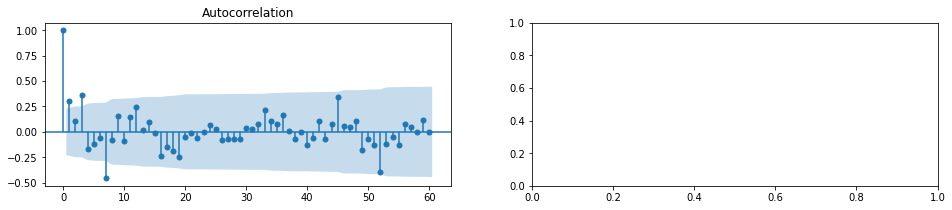

In [97]:
# Checking additive residuals diff 7 ACF and PACF
fig, axes = plt.subplots(1,2, figsize=(16,3))
plot_acf(add_resid_ts_diff_7, lags=60, ax=axes[0]);
plot_pacf(add_resid_ts_diff_7, lags=60, ax=axes[1], color='r');

### Checking forecast with raw data (w/ Renan)

In [ ]:
# Splitting data
# raw serie
split = 0.7
split_index = round(len(data_di)*split)
raw_train = data_di.iloc[:split_index]
raw_test = data_di.iloc[split_index:]


In [ ]:
# Trying Auto ARIMA with raw data
stepwise_fit_raw = pm.auto_arima(raw_train, start_p=0, start_q=0,
                             max_p=2, max_q=3, m=7,
                             start_P=0, seasonal=True,
                             d=1, D=1, trace=True,
                             error_action='ignore', # don’t want to know if an order does not work
                             suppress_warnings=True) # don’t want convergence warnings)
stepwise_fit_raw.summary()

In [ ]:
# m=1, AIC = 16354.856, Best model:  ARIMA(2,1,3)(0,0,0)[0]
# m=7, AIC = 16298.906, Best model:  ARIMA(0,1,2)(0,1,1)[7] 

In [ ]:
# Build model
sarima = SARIMAX(raw_train, order=(2, 1, 0),seasonal_order=(2,1,2,7))
sarima = sarima.fit()

# Forecast
results = sarima.get_forecast(len(raw_test), alpha=0.05)
forecast = results.predicted_mean
confidence_int = results.conf_int()

In [ ]:
confidence_int

In [ ]:
# Plotting

plot_forecast(forecast, raw_train, raw_test, upper = confidence_int['upper total_amount_claims'], lower=confidence_int['lower total_amount_claims'])


### A new approach to remove stationality since seasonal decompose removes a lot of data

In [ ]:
def plot_forecast(fc, train, test, upper=None, lower=None):
    is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
    # Prepare plot series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(upper, index=test.index) if is_confidence_int else None
    upper_series = pd.Series(lower, index=test.index) if is_confidence_int else None
    # Plot
    plt.figure(figsize=(10,4), dpi=100)
    plt.plot(train, label='training', color='black')
    plt.plot(test, label='actual', color='black', ls='--')
    plt.plot(fc_series, label='forecast', color='orange')
    if is_confidence_int:
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8);

In [ ]:
data_di.plot(grid=True, figsize=(15,5))

In [ ]:
detrended = np.log(data_di)
detrended.plot(grid=True, figsize=(15,5))

In [ ]:
# Differencing detrended series (exploring)

detrended_diff_1 = detrended.diff(1).dropna()
detrended_diff_2 = detrended.diff(1).diff(1).dropna()
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20,8))
ax1.plot(detrended); ax1.set_title('Original Series')
ax2.plot(detrended_diff_1); ax2.set_title('1st Order Differencing')
ax3.plot(detrended_diff_2); ax3.set_title('2nd Order Differencing');

In [ ]:
pvalue_y = adfuller(detrended_diff_1)[1]
pvalue_y
def stationary(pvalue):
    if pvalue < 0.05:
        print('TS is stationary')
    else:
        print('TS is not stationary')
stationary(pvalue_y), pvalue_y


In [ ]:
# Serie is stationary when d=1

In [ ]:
# Checking additive residuals detrended dif 1
fig, axes = plt.subplots(1,2, figsize=(16,3))
plot_acf(detrended_diff_1, lags=60, ax=axes[0]);
plot_pacf(detrended_diff_1, lags=60, ax=axes[1], color='r');

In [ ]:
# ARIMA 1,1,1 should be a good starting point. Max values for Auto ARIMA are 2,2

In [ ]:
# Splitting data
split = 0.7
split_index = round(len(detrended)*split)
detrended_train = detrended.iloc[:split_index]
detrended_test = detrended.iloc[split_index:]

In [ ]:
# Trying Auto ARIMA with detrended data
stepwise_fit_detrended = pm.auto_arima(detrended_train, start_p=0, start_q=0,
                             max_p=2, max_q=2, m=1,
                             start_P=0, seasonal=False,
                             d=1, D=1, trace=True,
                             error_action='ignore', # don’t want to know if an order does not work
                             suppress_warnings=True) # don’t want convergence warnings)
stepwise_fit_detrended.summary()

In [ ]:
# Build best model
sarima = SARIMAX(detrended_train, order=(0, 1, 1),seasonal_order=(0,0,0,0))
sarima = sarima.fit()

# Forecast
results = sarima.get_forecast(len(detrended_test), alpha=0.05)
forecast = results.predicted_mean
confidence_int = results.conf_int()



In [ ]:
forecast

In [ ]:
# Build Model
arima = ARIMA(detrended_train, order=(0, 1, 1))  
arima = arima.fit()
# Forecast
forecast_arima, std_err_arima, confidence_int_arima = arima.forecast(len(detrended_test), alpha=0.05)  # 95% confidence

In [ ]:
arima.summary()

In [ ]:
forecast_arima

In [ ]:
confidence_int_arima

In [ ]:
plot_forecast(forecast_arima, detrended_train, detrended_test)

In [ ]:

# re-compose back to initial time series

forecast_recons = np.exp(forecast_arima)
train_recons = np.exp(detrended_train)
test_recons = np.exp(detrended_test)
# lower_recons = np.exp(confidence_int['lower total_amount_claims'])
# upper_recons = np.exp(confidence_int['upper total_amount_claims'])

In [ ]:
# Plotting
plot_forecast(forecast_recons, train_recons, test_recons)


In [ ]:
test_recons

In [ ]:
# computing mae
arima_performance = pd.DataFrame(test_recons)
arima_performance['forecast_recons'] = forecast_recons


# arima_performance.dropna(inplace=True)

arima_performance['absolute_error'] = abs(arima_performance['total_amount_claims'] - arima_performance['forecast_recons'])
arima_performance
arima_performance['absolute_error'].mean()


### Training other ARIMA 

In [ ]:
# Build Model
arima = ARIMA(detrended_train, order=(2, 1, 0))  
arima = arima.fit()
# Forecast
forecast_arima, std_err_arima, confidence_int_arima = arima.forecast(len(detrended_test), alpha=0.05)  # 95% confidence

In [ ]:
arima.summary()

In [ ]:
confidence_int_arima = pd.DataFrame(confidence_int_arima, columns=['lower', 'upper'])

In [ ]:
forecast_arima

In [ ]:
plot_forecast(forecast_arima, detrended_train, detrended_test, upper= confidence_int_arima['upper'].values, lower= confidence_int_arima['lower'].values)





In [ ]:
# re-compose back to initial time series

forecast_recons = np.exp(forecast_arima)
train_recons = np.exp(detrended_train)
test_recons = np.exp(detrended_test)
lower_recons = np.exp(confidence_int_arima)['lower']
upper_recons = np.exp(confidence_int_arima)['upper']

In [ ]:
plot_forecast(forecast_recons, train_recons, test_recons, upper= upper_recons.values, lower= lower_recons.values)

In [ ]:
confidence_int_arima['upper'], np.exp(confidence_int_arima)['upper']

In [ ]:
forecast_arima, forecast_recons

In [ ]:
upper_recons

In [ ]:
# Plotting
plot_forecast(forecast_recons, train_recons, test_recons, upper= upper_recons.values, lower= lower_recons.values)

In [ ]:
# Inference validity checking residuals of our model

residuals = pd.DataFrame(arima.resid)
fig, ax = plt.subplots(1,2, figsize=(16,3))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1]);

In [ ]:
# computing mae
arima_performance = pd.DataFrame(test_recons)
arima_performance['forecast_recons'] = forecast_recons


# arima_performance.dropna(inplace=True)

arima_performance['absolute_error'] = abs(arima_performance['total_amount_claims'] - arima_performance['forecast_recons'])
arima_performance
arima_performance['absolute_error'].mean()

In [ ]:
# Model has poor performance

### New approach: applying diff to raw data

In [ ]:
# Differencing additive residuals series
data_di_diff_1 = data_di.diff(1).dropna()

In [ ]:
# Plotting
f, (ax1, ax2) = plt.subplots(1,2, figsize=(20,6))
ax1.plot(data_di); ax1.set_title("Raw Data")
ax2.plot(data_di_diff_1); ax2.set_title("1st Order Differencing");

In [ ]:
pvalue_y = adfuller(data_di_diff_1)[1]
pvalue_y
def stationary(pvalue):
    if pvalue < 0.05:
        print('TS is stationary')
    else:
        print('TS is not stationary')
stationary(pvalue_y), pvalue_y


In [ ]:
# Checking additive residuals detrended dif 1
fig, axes = plt.subplots(1,2, figsize=(16,3))
plot_acf(data_di_diff_1, lags=60, ax=axes[0]);
plot_pacf(data_di_diff_1, lags=60, ax=axes[1], color='r');

In [ ]:
# Splitting data
split = 0.7
split_index = round(len(data_di)*split)
train = data_di.iloc[:split_index]
test = data_di.iloc[split_index:]

In [ ]:
# Running ARIMA with d=1, p=2, q=1
# Build Model
arima = ARIMA(train, order=(2, 1, 1))  
arima = arima.fit()
# Forecast
forecast_arima, std_err_arima, confidence_int_arima = arima.forecast(len(detrended_test), alpha=0.05)  # 95% confidence

In [ ]:
arima.summary()

In [ ]:
confidence_int_arima = pd.DataFrame(confidence_int_arima, columns=['lower', 'upper'])

In [ ]:
plot_forecast(forecast_arima, train, test, upper= confidence_int_arima['upper'].values, lower= confidence_int_arima['lower'].values)
